In [1]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

# Learning curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

# Feature engineer 
from feature_engine.selection import DropFeatures
#from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
#from sklearn.preprocessing import OneHotEncoder 
from feature_engine.outliers import Winsorizer, ArbitraryOutlierCapper
from feature_engine.imputation import (AddMissingIndicator, MeanMedianImputer, CategoricalImputer)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline

# Model_Selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

In [12]:
from sklearn import set_config
set_config(display='diagram')

# Load the Data

In [3]:
def load_data():
    global df
    df = pd.read_csv("Dados/train.csv",index_col=0)
    global df_pred
    df_pred = pd.read_csv("Dados/test.csv",index_col=0)
    global x
    x = df.drop('Survived',axis=1)
    global y
    y = df.Survived
    global seed
    seed = 42
    
    global x_train, x_test, y_train, y_test
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state = 0)
    
    global num_var, cat_var, target
    num_var = ['Pclass','Age','SibSp','Parch','Fare','Cabin_Size']
    cat_var = ['Sex','Cabin_code','Embarked','Name_Title', 'Name_family']
    target = ['Survived']

In [4]:
load_data()

In [5]:
x_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
858,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S
53,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
387,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S
125,1,"White, Mr. Percival Wayland",male,54.0,0,1,35281,77.2875,D26,S
579,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C


# Functions

In [7]:
class dtype_fix_class(BaseEstimator,TransformerMixin):
    """ corrects dtype of all initial features"""
    
    def __init__(self, Pclass_type='O',SibSpParch_type=None):
        self.Pclass_type=Pclass_type
        self.SibSpParch_type=SibSpParch_type
        pass
    
    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        return self
    
    def transform(self, x:pd.DataFrame,y:pd.Series=None):
        df=x.copy()
        try:
            if self.Pclass_type=='O':
                df['Pclass']=df['Pclass'].astype('object')
            else :
                df['Pclass']=df['Pclass'].astype('int')
            if self.SibSpParch_type=='O':
                df['SibSp']=df['SibSp'].astype('object')
                df['Parch']=df['Parch'].astype('object')               
            df['Fare']=df['Fare'].astype('float')
            df['Sex']=df['Sex'].astype('object')
            df['Age']=df['Age'].astype('float')
            df['Cabin']=df['Cabin'].astype('object')
            df['Embarked']=df['Embarked'].astype('object')
        except:
            print('erro em dtype_fix')
        return df
    
# using FunctionTransformer
def dtype_func(x:pd.DataFrame,y:pd.Series=None):
    df=x.copy()
    df['Pclass']=df['Pclass'].astype('O')
    return df
dtype_fix = FunctionTransformer(dtype_func)

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate plot: the test and training learning curve
    """
    if axes is None:
        _, axes = plt.subplots(1, figsize=(20, 10))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring='accuracy',
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    print('train_scores_mean: ',train_scores_mean[-1], '\ntest_scores_mean',test_scores_mean[-1])
    return plt

def get_cross_score(pipe,cv=5):
    score = cross_val_score(pipe, x_train, y_train, cv=cv, scoring='accuracy')
    print(f'accuracy of {np.round(score.mean(),4)} and standard deviation of {np.round(score.std(),4)}')
    
def make_sub(pipe,subname):
    pipe.fit(x,y)
    pred = pipe.predict(df_pred)
    data = {'PassengerId': df_pred.index,
                 'Survived': pred}
    sub1 = pd.DataFrame(data)
    sub1.to_csv('Predições/Experiments_nb/' +subname+'.csv',header=True, index=False)

# Baseline

In [17]:
# baseline simple pipeline
pipe_base = make_pipeline(
                        MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                        RandomForestClassifier(random_state=42))
get_cross_score(pipe_base,5)

accuracy of 0.6581 and standard deviation of 0.0097


So we have our baseline model and score now.

set_config(display='diagram') shows pipelines structures in HTML

In [19]:
from sklearn import set_config

set_config(display='diagram')
#pipe_base

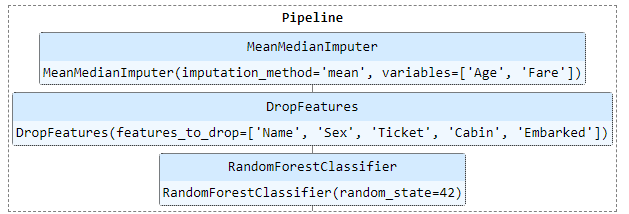

# Feature Engineer

## Numeric Varibles

### SibSp and Parch

Numerical features ready to be feeded to the model. Might need to be scaled.

### "Age"

There's only one thing to be done in Age: impute missing values. Let's check how each imputing strategy behaves.

In [26]:
# baseline simple pipeline
pipe_age = make_pipeline(DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          MeanMedianImputer(imputation_method='median', variables=['Age','Fare']),
                          RandomForestClassifier(random_state=seed))
get_cross_score(pipe_age,5)

accuracy of 0.6517 and standard deviation of 0.0129


Imputing with median lowers slightly the acc.

In [21]:
# baseline simple pipeline
pipe_age2 = make_pipeline(DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True),
                          RandomForestClassifier(random_state=seed))
get_cross_score(pipe_age2,5)

accuracy of 0.6548 and standard deviation of 0.0253


Add a missing indicator doesn't help either.

Sklearn SimpleImputer imputes each feature with it's mean, meadian or mode. We can create a custom imputer to impute the mean of more specific groups than just the whole feature. 

In [45]:
print('age mean: ', x_train['Age'].mean())
print('male age mean: ', x_train[x_train['Sex']=='male']['Age'].mean())
print('female age mean: ', x_train[x_train['Sex']=='female']['Age'].mean())

print('Pclass 1 age mean: ', x_train[x_train['Pclass']==1]['Age'].mean())
print('Pclass 2 age mean: ', x_train[x_train['Pclass']==2]['Age'].mean())
print('Pclass 3 age mean: ', x_train[x_train['Pclass']==3]['Age'].mean())

age mean:  29.915338645418327
male age mean:  30.728593272171253
female age mean:  28.395714285714284
Pclass 1 age mean:  38.15382352941177
Pclass 2 age mean:  29.462936507936508
Pclass 3 age mean:  25.484375


In the following example we create a custom imputer to impute missing values for age based on the mean of 2 grouped features. Unless we discretize the numerical features, we're going to have to pick categorical features to group by. Pclass and sex both have big predictive pontential and diferent means for each class, so it seems logical to group by those two.

In [46]:
class AgeGroupImputer(BaseEstimator, TransformerMixin):
    """Impute missing values with the mean of the group"""
    def __init__(self,group:list=['Pclass','Sex']):
        super().__init__()
        self.group = group
        self.age_means_ = {}

    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        self.age_means_ = x.groupby(self.group).Age.mean()
        return self

    def transform(self, x:pd.DataFrame, y:pd.Series=None):
        x = x.copy()
        for key, value in self.age_means_.items():
            x.loc[((np.isnan(x["Age"])) & (x[self.group[0]] == key[0]) & (x[self.group[1]] == key[1])), 'Age'] = value

        return x

In [47]:
gp = AgeGroupImputer(group=['Pclass','Sex'])
x_age = gp.fit_transform(x_train)
gp.age_means_

Pclass  Sex   
1       female    34.934426
        male      40.772267
2       female    29.405660
        male      29.504521
3       female    20.979508
        male      27.019553
Name: Age, dtype: float64

In [48]:
pipe_age = make_pipeline(AgeGroupImputer(group=['Pclass','Sex']),
                        DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_age,5)
pipe_age

accuracy of 0.6917 and standard deviation of 0.026


Pipeline(steps=[('agegroupimputer', AgeGroupImputer()),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Sex', 'Ticket',
                                                'Cabin', 'Embarked'])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

There was a improvement of almost 4% in acc by imputing the values for Age by Pclass and Sex goupby.

### "Fare"

Tree algorithms usually doesn't benefit much from scaling numerical features but let's try it anyway.

In [22]:
pipe_fare = make_pipeline(DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          MinMaxScaler(),
                          SimpleImputer(missing_values=np.nan, strategy='mean'),
                          RandomForestClassifier(random_state=seed))
get_cross_score(pipe_fare,5)

accuracy of 0.6581 and standard deviation of 0.0097


Acc didn't change.

## Categorical Variables

### "Name"

Extract Title and Family name from feature "Name"

In [77]:
class get_feature_name(BaseEstimator, TransformerMixin):
    """create column with family name  and title of each passenger"""
    def __init__(self, title:bool=True,family:bool=True):
        self.title = title
        self.family = family
        pass
    
    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        return self
    
    def transform(self, x:pd.DataFrame, y:pd.Series=None):
        df = x.copy()
        try:
            if self.title:
                df['Name_title'] = df['Name'].apply(lambda x: x.split(",")[1]).apply(lambda x: x.split(".")[0])
            if self.family:
                df['Name_family'] = df['Name'].apply(lambda x: x.split(",")[0])
            
        except:
            print('erro em get_name')
        return df

x_train_ = get_feature_name(family=True,title=True).fit_transform(x_train)
x_train_.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Name_family
PassengerId,,,,,,,,,,,,
858,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S,Mr,Daly
53,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C,Mrs,Harper
387,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S,Master,Goodwin
125,1,"White, Mr. Percival Wayland",male,54.0,0,1,35281,77.2875,D26,S,Mr,White
579,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C,Mrs,Caram


In [32]:
def feat_name(x:pd.DataFrame, y:pd.Series=None):
    """ extracs family name and title from the feature Name """
    df = x.copy()
    df['Name_title'] = df['Name'].apply(lambda x: x.split(",")[1]).apply(lambda x: x.split(".")[0])
    df['Name_family'] = df['Name'].apply(lambda x: x.split(",")[0])
    return df
get_feature_name = FunctionTransformer(feat_name)

In [51]:
x_train_ = get_feature_name.transform(x_train)
x_train_.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Name_family
PassengerId,,,,,,,,,,,,
858,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S,Mr,Daly
53,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C,Mrs,Harper
387,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S,Master,Goodwin
125,1,"White, Mr. Percival Wayland",male,54.0,0,1,35281,77.2875,D26,S,Mr,White
579,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C,Mrs,Caram


In [52]:
family_labels = pd.DataFrame(x_train_['Name_family'].value_counts())
print(f'Amount of unique labels in family name:', family_labels.shape[0])
print(f'\n Family names with more than 3 occurrences:')
family_labels[family_labels["Name_family"]>3]

Amount of unique labels in family name: 502

 Family names with more than 3 occurrences:


,Name_family
Sage,7
Andersson,7
Brown,4
Rice,4
Carter,4
Lefebre,4
Ford,4
Goodwin,4


"Name_family" is now a categorical feature and we'll have to encode it so the model can use it.

In [53]:
title_labels = pd.DataFrame(x_train_['Name_title'].value_counts())
print(f'Amount of unique labels in title:', title_labels.shape[0])
print(f'\nTitles with more than 3 occurrences:')
title_labels[title_labels["Name_title"]>3]

Amount of unique labels in title: 14

Titles with more than 3 occurrences:


,Name_title
Mr,367
Miss,121
Mrs,88
Master,31


In [42]:
pipe_name_title = make_pipeline(
    
                        #categorical features transformations
                          get_feature_name,
                          DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                          RareLabelEncoder(max_n_categories=8,tol=0,variables=['Name_family']),
                          RareLabelEncoder(max_n_categories=4,tol=0,variables=['Name_title']),
                          OneHotEncoder(variables=['Name_title','Name_family']),
                        # numeric features transformations
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                        RandomForestClassifier(random_state=42))
get_cross_score(pipe_name_title,5)

accuracy of 0.7946 and standard deviation of 0.0494


### Sex

Sex needs to be binary encoded. Let's develop a "Mapper" class to make this transformation.

In [73]:
class Mapper(BaseEstimator, TransformerMixin):
    """ Encode variables with the map_dict param """
    
    def __init__(self,variables:list,map_dict:dict):
        
        if not isinstance(variables,list):
            raise ValueError('variables should be a list')
            
        self.variables = variables
        self.map_dict = map_dict
        pass
    
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame):
        x = x.copy()
        
        for feature in self.variables:
            x[feature] = x[feature].map(self.map_dict)
        return x


In [38]:
def mapper_func(x:pd.DataFrame, y=None):
    x = x.copy()
    x['Sex'] = x['Sex'].map({'male':1,
                             'female':0})
    return x
Mapper = FunctionTransformer(mapper_func)

In [40]:
#dict for enconding "Sex"
sex_map = {'male':1, 'female':0}

pipe_sex_base = make_pipeline(
                        #categorical features transformations
                          Mapper,
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                          RandomForestClassifier(random_state=42)
                            )

get_cross_score(pipe_sex_base,5)
pipe_sex_base

accuracy of 0.7978 and standard deviation of 0.0332


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function mapper_func at 0x000001B9339EE1F0>)),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'Ticket', 'Cabin',
                                                'Embarked'])),
                ('meanmedianimputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Age', 'Fare'])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

Sex improves acc a great deal versus the baseline.

Let's add the Mapper on top of our current best model.

In [50]:
pipe_sex = make_pipeline(
                        #categorical features transformations
                          get_feature_name,
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked']),
                          RareLabelEncoder(max_n_categories=8,tol=0,variables=['Name_family']),
                          RareLabelEncoder(max_n_categories=4,tol=0,variables=['Name_title']),
                          OneHotEncoder(variables=['Name_title','Name_family']),
                          Mapper,
                        # numeric features transformations
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_sex,5)

accuracy of 0.7962 and standard deviation of 0.0364


In [81]:
pipe_sex = make_pipeline(
                        #categorical features transformations
                          get_feature_name(family=True,title=True),
                          AgeGroupImputer(group=['Pclass','Sex']),
                        #categorical features transformations
                          Mapper(variables=['Sex'],map_dict = sex_map),
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked']),
                          OneHotEncoder(variables=['Name_title','Name_family']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Fare']),
                        # model  
                          RandomForestClassifier(random_state=0))

#dict for enconding "Sex"
sex_map = {'male':1,
           'female':0}

get_cross_score(pipe_sex,5)
#pipe_sex

accuracy of 0.8347 and standard deviation of 0.0323


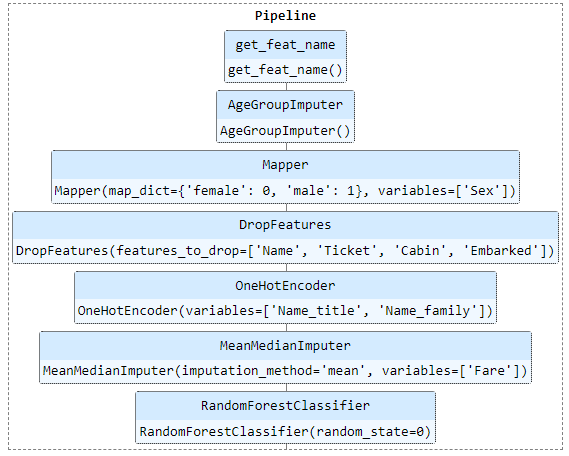

Adding Sex on top of Name_title doesn't change accuracy. An hipotesis is that Name_title already carries the info about sex, since "Rare" has only 16 occurences and nearly all women fall under "Miss" and "Mrs", therefore, the feature Sex doesn't reduces the cost function enough to become a node in the decision tree.

Let's check the relation between Title and Age too with a violinplot.

C:\Users\ticom\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


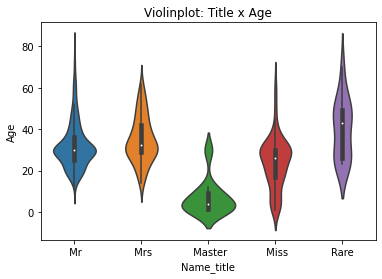

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

pipe_violin_title_age = make_pipeline(    
                        #categorical features transformations
                          get_feature_name(family=True,title=True),
                          RareLabelEncoder(max_n_categories=4,tol=0,variables=['Name_title']),
                          Mapper(features=['Sex'],map_dict=sex_map),
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),)
x_train_2 = pipe_violin_title_age.fit_transform(x_train)

sns.violinplot(x_train_2['Name_title'],x_train_2['Age'])
plt.title('Violinplot: Title x Age')
plt.show()

Master has considerably lower Age mean and the interquartiles of "Mrs" and "Miss" differ too. Title carries some info about age.

### Cabin

In [11]:
class Cabin_code(BaseEstimator, TransformerMixin):
    """Create column with first character of the first Cabin and how many cabins"""
    
    def __init__(self,code=True,size=True):
        self.code=code
        self.size=size
        pass
        
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame,y:pd.Series=None):
        x = x.copy()
        try:
            if self.code:
                x['Cabin_code'] = x['Cabin'].apply(lambda x: x[0])
            if self.size:
                x['Cabin_Size'] = x['Cabin'].apply(lambda x: len(x.split(" ")))
        except Exception as err:
            print('erro no Cabin_code')
            print(err)
        return x

In [52]:
def cabin_func(x:pd.DataFrame,y:pd.Series=None):
    x = x.copy()
    x['Cabin_code'] = x['Cabin'].apply(lambda x: x[0])
    x['Cabin_Size'] = x['Cabin'].apply(lambda x: len(x.split(" ")))
    return x

Cabin_code = FunctionTransformer(cabin_func)

In [53]:
pipe_cabin_base = make_pipeline(
                        # extract features
                          CategoricalImputer(variables='Cabin',fill_value='?'),
                          Cabin_code,
                        #categorical features transformations
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked','Sex']),
                          OneHotEncoder(variables=['Cabin_code']),
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                        RandomForestClassifier(random_state=42))
get_cross_score(pipe_cabin_base,5)
#pipe_cabin_base

accuracy of 0.6597 and standard deviation of 0.0195


Cabin_code and Cabin_size does't seem to be picked up by the tree.

Let's see how it goes if we add it on top of our current pipeline:

In [86]:
pipe_cabin = make_pipeline(
                        # extract features
                          get_feature_name(family=True,title=True),
                          CategoricalImputer(variables='Cabin',fill_value='?'),
                          Cabin_code(code=True,size=True),
    
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Fare','Age']),
                          #AgeGroupImputer(group=['Pclass','Sex']),
    
                        #categorical features transformations
                          Mapper(variables=['Sex'],map_dict = sex_map),
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked']),
                          OneHotEncoder(variables=['Name_title','Name_family','Cabin_code']),

                        # model  
                          RandomForestClassifier(random_state=0))

#dict for enconding "Sex"
sex_map = {'male':1,
           'female':0}

get_cross_score(pipe_cabin,5)
#pipe_cabin

accuracy of 0.8251 and standard deviation of 0.0268


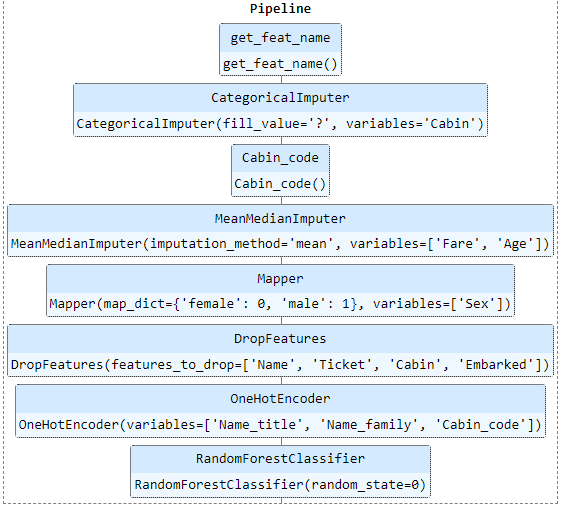

Cabin_code and Cabin_size decreases the acc very slightly when applied in this pipeline to a RandomForestClassifier.

### Embarked 

Embarked is categorical, we're going to impute missing values with mode and OneHotEncode it.

In [54]:
pipe_embarked_base = make_pipeline(
                        # numerical features transformation
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        #categorical features transformations
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Sex']),
                          CategoricalImputer(variables=['Embarked'],fill_value='C'),
                          OneHotEncoder(variables=['Embarked']), 
                       # model  
                          RandomForestClassifier(random_state=42))
get_cross_score(pipe_embarked_base,5)
#pipe_embarked_base

accuracy of 0.6645 and standard deviation of 0.0173


## Ordinal Variables

### Pclass

In [28]:
# baseline simple pipeline
pipe_base = make_pipeline(
                        dtype_fix,
                        MeanMedianImputer(imputation_method='mean', variables=['Age']),
                        DropFeatures(features_to_drop=['Name','Sex','Ticket','Cabin','Embarked']),
                        OneHotEncoder(variables=['Pclass'],drop_last=False),
                        RandomForestClassifier(random_state=seed))
get_cross_score(pipe_base,5)

accuracy of 0.6549 and standard deviation of 0.0191


# Fix Rare Labels

Custom transformer to treat rare labels

If we're to use Scikit Learn approach instead of feature-engine (it returns pd.DataFrame instead of np.array and let's you select which columns each transformer will be applied by name), we're going to need to develop a custom transformer to deal with rare labels. 

In [54]:
class fix_rare_labels(BaseEstimator,TransformerMixin):
    """transforms rare labels values in 'Rare'.
      Make sure to use the same order calling "variables" for train and predict"""
    
    def __init__(self,variables:list,threshold:list):
        super().__init__()
        self.threshold = threshold  #frequency threshold
        #self.freq_list= []
        self.variables = variables
        self.freq_labels = []
        pass
    
    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        """ Saves in memory a list of which each item is a list 
            of frequent labels for a initializes variable """

        x = x.copy()
        try:
            # for each variable
            for c,var in enumerate(self.variables):
                # dic with keys for unique labels and occurrence count of said label for value 
                label_occurrence = x[var].value_counts().to_dict()
                # initialize an empty list for the frequent labels of var
                frequent_by_feat = []
                # loop for each unique label of var
                for (key,value) in label_occurrence.items():
                    # if the label has more than threshold occurrences
                    if value > self.threshold[c]:
                        # append this label to the list of frequent labels of var
                        frequent_by_feat.append(key)
                # append the list of frequent labels of this feature to a list. 
                # "freq_labels" is a list of wich each item is a list of frequent labels for a variable
                    # exp.: the first item of "freq_labels" is a list of frequent labels 
                    # for the first var from self.variables and so on
                self.freq_labels.append(frequent_by_feat)
                
        except Exception as err:
            print(err)
            print('error in fix_rare_labels fit')
        return self
    
    def transform(self, x:pd.DataFrame, y:pd.Series=None):
        """ replaces rare labels for the str "Rare" """
        x = x.copy()
        try: 
            # loop for each feature
            for c,var in enumerate(self.variables):
                # dataframe with unique labels as index and occurrence count of said label as values for this loop's feat
                label_occurrence = pd.DataFrame(x[var].value_counts())
                # loop for each unique label
                for unique_label in label_occurrence.index:
                    # we need a df with value True of False if the label from index is in list of frequent labels 
                    # if label is in list of frequent labels of his feature
                    if unique_label in self.freq_labels[c]:
                        # replace the occurrence count with "False"
                        label_occurrence.loc[unique_label]= False
                    else:
                        # replace the occurrence count with "True"
                        label_occurrence.loc[unique_label]= True
                # transform list to boolean type
                label_occurrence_bool = (label_occurrence.iloc[:,0]).astype(bool)
                # replaces rare labels for the string "Rare"
                x[var] = x[var].mask(x[var].map(label_occurrence_bool),"Rare")
        except Exception as err:
            print('error in fix_rare_labels transform') 
            print(err)
        return x

In [55]:
fl = fix_rare_labels(variables=['Name_family', 'Name_title'], threshold=[3,10])
x_rare = fl.fit_transform(x_train_)
fl.freq_labels

[['Sage',
  'Andersson',
  'Brown',
  'Rice',
  'Carter',
  'Lefebre',
  'Ford',
  'Goodwin'],
 [' Mr', ' Miss', ' Mrs', ' Master']]